In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import waterfall_chart
import random

In [2]:
df = pd.read_stata("HCMST 2017 fresh sample for public sharing draft v1.1.dta")

### Wybór zmiennych

In [3]:
df['y'] = 1 - df['S1'].cat.codes

1. Zmienne jakościowe  
a) `Q25` - Did you and [Partner name] attend the same high school?  
b) `ppmarit` -  Marital Status  

2. Zmienne ilościowe  
a) `ppincimp` - Household Income  
b) `Q16` - How many of your relatives do you see in person at least once a month?
 Include parents, brothers and sisters, uncles, aunts, cousins,
 grandparents, or others.   

In [4]:
columns = ['Q25', 'ppmarit', 'ppincimp', 'Q16', 'y']

In [5]:
df = df[columns].dropna()

In [6]:
X = df[columns[:4]].copy()
X.loc[:, columns[:3]] = X[columns[:3]].apply(lambda x: x.cat.codes, axis=0)
y = df['y']

### Model

In [7]:
gbm = xgb.XGBClassifier(
     learning_rate =0.1,
     n_estimators=50,
     max_depth=8,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective='binary:logistic',
     nthread=4,
     scale_pos_weight=1,
     seed=27).fit(X, y)

### Zmiana w średniej odpowiedzi modelu

In [8]:
def plot_mean_response(X, model, **kwargs):
    X = X.copy()
    y = [model.predict_proba(X)[:,1].mean()]
    for kwarg in kwargs:
        X.loc[:, kwarg] = kwargs[kwarg]
        y.append(model.predict_proba(X)[:,1].mean())
    waterfall_chart.plot(['intercept'] + list(kwargs.keys()), [y[0]] + list(np.diff(y)), formatting='{:,.2f}')

a) `Q25` - Did you and [Partner name] attend the same high school?  
b) `ppmarit` -  Marital Status  
c) `ppincimp` - Household Income  
d) `Q16` - How many of your relatives do you see in person at least once a month?

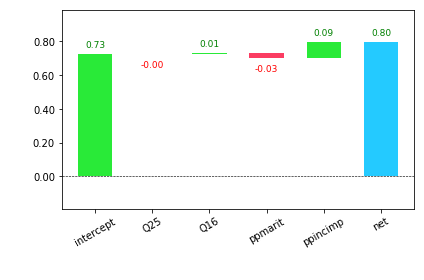

In [9]:
plot_mean_response(X, gbm, Q25=2, Q16=9, ppmarit=3, ppincimp=13)

W tej analizie widać delikatny spadek predykcji w przypadku gdy dana osoba jest rozwiedziona (ppmarit=3) oraz nadrobienie tych strat kiedy okazuje się, że osoba jest dosyć zamożna.

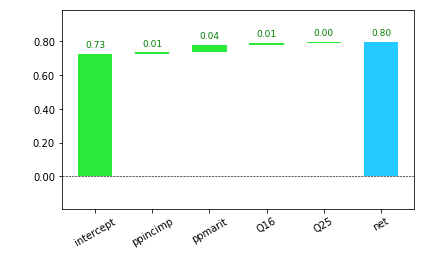

In [10]:
plot_mean_response(X, gbm, ppincimp=13, ppmarit=3, Q16=9, Q25=2)

Zmiana kolejności warunkowania spowodowała zmianę interpretacji. Wynika to z faktu, że jeśli wiemy, że dana osoba jest zamożna to fakt, że jest rozwiedziona przestaje przeszkadzać a nawet powoduje wzrost predykcji. Jest to trochę sprzeczne z intuicją dlatego należałoby dokładniej zbadać model.

## Lime

Wybór obserwacji

In [11]:
x_idx = 2033
x = X.loc[x_idx]
x

Q25          2.0
ppmarit      3.0
ppincimp    13.0
Q16          9.0
Name: 2033, dtype: float64

Utworzenie zbioru obserwacji podobnych  
Zbiór będę generował poprzez zmianę zmiennych:  
1. `ppmarit` -  Marital Status  
2. `Q16` - How many of your relatives do you see in person at least once a month?

Generowanie permutacji:   
Zbiór permutacji będę generował poprzez zamianę ustalonej zmiennej na losową wartość danej cechy w zbiorze zródłowym. Dzięki takiemu zabiegowi (w przeciwieństwie do losowej liczby) zachowujemy rozkład danej cechy w zbiorze. 

In [12]:
X_gen = pd.DataFrame([x]*1000)
X_gen["Q16"] = X.iloc[random.sample(range(len(X)), len(X_gen))]["Q16"].values
X_gen["ppincimp"] = X.iloc[random.sample(range(len(X)), len(X_gen))]["ppincimp"].values

Wyznaczenie predykcji modelu czarnej skrzynki

In [13]:
y_pred_blackbox = gbm.predict_proba(X_gen)[:,1]

Wyznaczenie podobieństwa wygenerowanych obserwacji do obserwacji x (obserwacji generującej).  
Odległość standaryzuje przez wariancję kolumn

In [42]:
def distance_x(x, q16, ppincimp):
    d_q16 = np.abs(q16-x["Q16"]) / X.var(axis=0)["Q16"]
    d_ppincimp = np.abs(ppincimp-x["ppincimp"]) / X.var(axis=0)["Q16"]
    return d_q16 + d_ppincimp

X_gen["distance"] = [distance_x(x, q16, ppincimp) for q16, ppincimp in zip(X_gen["Q16"], X_gen["ppincimp"])]

Dopasowanie modelu białej skrzynki

In [51]:
from sklearn.tree import DecisionTreeRegressor
model_whitebox = DecisionTreeRegressor(max_depth = 2)
model_whitebox.fit(X_gen[["Q16", "ppincimp"]], y_pred_blackbox, sample_weight=X_gen["distance"].values)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [52]:
#import os     
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'
#!pip install pydotplus

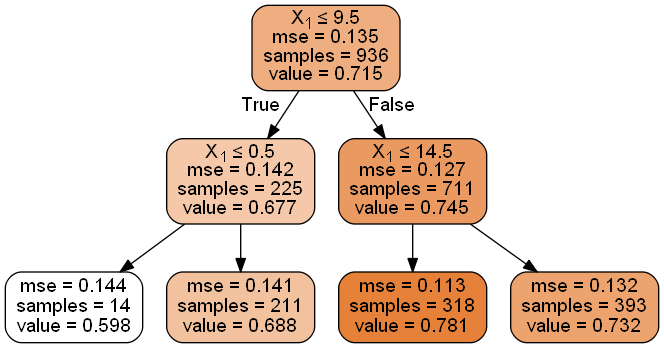

In [53]:
# Visualisation based on code example:
# https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model_whitebox, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [48]:
x

Q25          2.0
ppmarit      3.0
ppincimp    13.0
Q16          9.0
Name: 2033, dtype: float64

We wszystkich wierzchołkach drzewa (o głębokości równej 2) cecha `ppincimp` okazała się posiadać większą moc predykcyjną niż informacja ilu krewnych widuje się przynajmniej raz w miesiącu.  
Wyniki pokrywają się ze spostrzeżeniami z poprzedniego badania gdzie druga cecha miała marginalny wpływ na predykcję.

Predykcja uzależniona jest nieliniowo od statusu materialnego. Najwyższa predykcja przypada na zarobki od 35tys do 85tys dolarów rocznie. Wyniki można uznać za wiarygodne ze względu na wystarczająco dużą liczbę przypadków w każdym liściu.

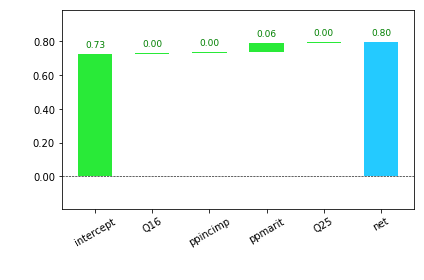

In [49]:
plot_mean_response(X, gbm, Q16=9, ppincimp=13, ppmarit=3, Q25=2)

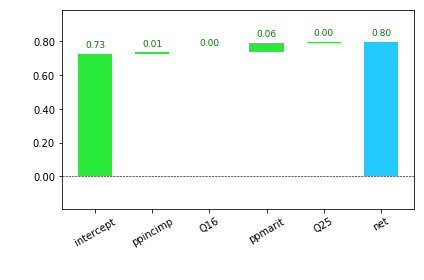

In [50]:
plot_mean_response(X, gbm, ppincimp=13, Q16=9, ppmarit=3, Q25=2)

Niezależnie od kolejności warunkowania cecha `Q16` nie odgrywa roli dla analizowanego przypadku x.